# Trajectory classification - analyses using RMSD

To determine the melting temperature, one often needs to determine reference structures. These reference strctures would represent different meta-stable folded configurations. In this example, we perform this analysis for a palindromic seven residue DNA hairpin.

## The trajectory

The system to be studied in this particular example involves several stable or metastable configurations which differ in their structure only very little. The natively folded strcture is the most populated. It involves the formation of a three nucleotide loop and then a zipping of the stem bases of the single stranded DNA. The central nucleotide in the loop is stacked on one of the other two nucleotides, which form a sheared base-pair (allowing them to form a loop with only three nucleotides - it takes 4 or more for RNA). The "misfolded" states identified involve these possible differences with respect to the natively folded state

1. A switch between syn and anti configuration of the loop residues
2. Stacking on the nucleotide different from the one in the native state
3. Zipping of the step without the base-pairing of the loop residues - they merely stack as well

These states can be separated from the natively folded structures without performing explicit clustering using a simple RMSD histogram analysis (coupled with a loop native contacts analysis - this is a work in progress). It is not necessarily a replacement for clustering but could be a way to get an intuition for the conformations taken by the molecule while obtaining some representative structures with respect to which one can perform the melting temperature analyses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from MDAnalysis.analysis import rms, distances
    from MDAnalysis import Writer as mdawriter
    from MDAnalysis.transformations import unwrap


from functools import partial
from typing import List, Tuple, Any
from numpy.typing import NDArray

from pathlib import Path
import os
import re

from mc_trex.post_processing import dna_non_bonded, native_contacts, traj_classification
from mc_trex.post_processing.fit_func import sigmoid_for_dist, sigmoid_for_ang

In [2]:
top = "./example1.prmtop"
trj = "./example1.nc"

In [3]:
wrapped_traj = mda.Universe(top, trj)

## Using RMSD to separate frames

We begin by 
1. loading trajectory
2. selecting 3 random frames from the complete trajectory to serve as the references
3. calculating the RMSD with respect to these frames
4. generating histograms of these RMSD time series
5. separating peaks

Repeating this process along with some observation of the placement of the RMSD values can help iteratively separate frames. Since the RMSD distributions usually have a Gaussian-like spread about a mean value, we can expect there to be some contamination of the identified groups. 

In [9]:
# RMSDAnalysis instance for example1 
ra = traj_classification.RMSDAnalysis()

## Unwrapping coordinates

The trajectory needs to be unwrapped for the analyses. In GROMACS, there are tools to do this. The trajectory used in this notebook was run using AMBER with wrapping off. So there is no need to unwrap. However, this is how one would go about doing it.

In [10]:
wrapped_coords = wrapped_traj.trajectory.timeseries(atomgroup=wrapped_traj.select_atoms("all"))

## Performing the initial split

1. Extract all coordinates
2. Create curr_coords array
3. Length of each curr_coord in curr_coords is the number of frames in splits
4. Generate nrefs random frames for each split
5. Calculate RMSD for each split with respect to each ref for that split
6. Bin each RMSD
7. Find cuts for each RMSD
8. Extract the splits from the RMSD determined
9. Put these into different splits and then into curr_coords

In [24]:
# Definiing variables for the method itself
n_splits = 2
nrefs = 2
nc_selection = "and nucleic and not type H*"
selection = " ".join(nc_selection.split()[1:])
traj_coords = wrapped_traj.trajectory.timeseries(wrapped_traj.select_atoms(selection))
out_loc = "/home/nithinkomathrajendran/all_repos/mc_trex/docs/examples/"
out_name = "aligned"

# Defining order of methods to try, tolerances to use, the limits beyond which cut-offs will be ignored
methods = ["rmsd"] #, "native"]
tols = [1.0, 0.01]
lims = [4.0, 0.7]

# No more than max_components peaks will be fit - set to some reasonably high value
max_components = 10

# Seed for the frame selector
seed = 42
np.random.seed(seed)

# Will contain frame indices from each split  
splits = {0:np.arange(traj_coords.shape[0])}

# Variables that will be set during the run
curr_coords = [traj_coords]

In [23]:
# Loop over the number of splitting iterations
for split_num in range(n_splits):

    # From each split generated so far, get the number of frames
    n_frames = [split.shape[0] for split in splits[split_num]]

    # Select random reference frames for each split in the trajectory
    ref_frames = [np.random.randint(low=0, high=n_frame, size=nrefs) for n_frame in n_frames]

    # For each method
    for method in methods:
        if method == "rmsd":
            ra1 = traj_classification.RMSDAnalysis()
            step_cuts = []

            splits[split_num+1] = []
            
            for split_frames, ref_frame_set in zip(splits[split_num], ref_frames):
                split_rmsds = [[rms.rmsd(split_frame, ref_frame, superposition=True) for split_frame in split_frames] for ref_frame in ref_frame_set]
                split_bins = ra1.bin_frames(split_rmsds, bins=np.shape(split_rmsds)[-1]//10)
                split_cuts = ra1.get_cuts(split_bins, max_components=max_components)
                split_sort_frames = ra1.sort_frames()
        break

IndexError: tuple index out of range

In [157]:
splits[split_num]

array([    0,     1,     2, ..., 36726, 36727, 36728])

In [32]:
nrefs = 3
np.random.seed(42)
refs = np.random.randint(low=0, high=traj.trajectory.n_frames, size=nrefs)

Next we extract the frames and create universes.

In [39]:
full_refs = [mda.Universe(top, coords[idx, :, :]) for idx in refs]

In [122]:
ra.traj = wrapped_traj
ra.refs = full_refs

In [36]:
filenames = ["/home/nithinkomathrajendran/all_repos/mc_trex/docs/examples/aligned" + str(i+1) + ".nc" for i in range(3)]

full_rmsds = ra.get_similarity_metric(filenames=filenames, select="nucleic and not type H*")

In [42]:
full_hist = ra.bin_frames(full_rmsds, bins=3000)

Instead of choosing `auto`, the bin count was explicitly set to have a sufficient number bins considering the large number of frames.

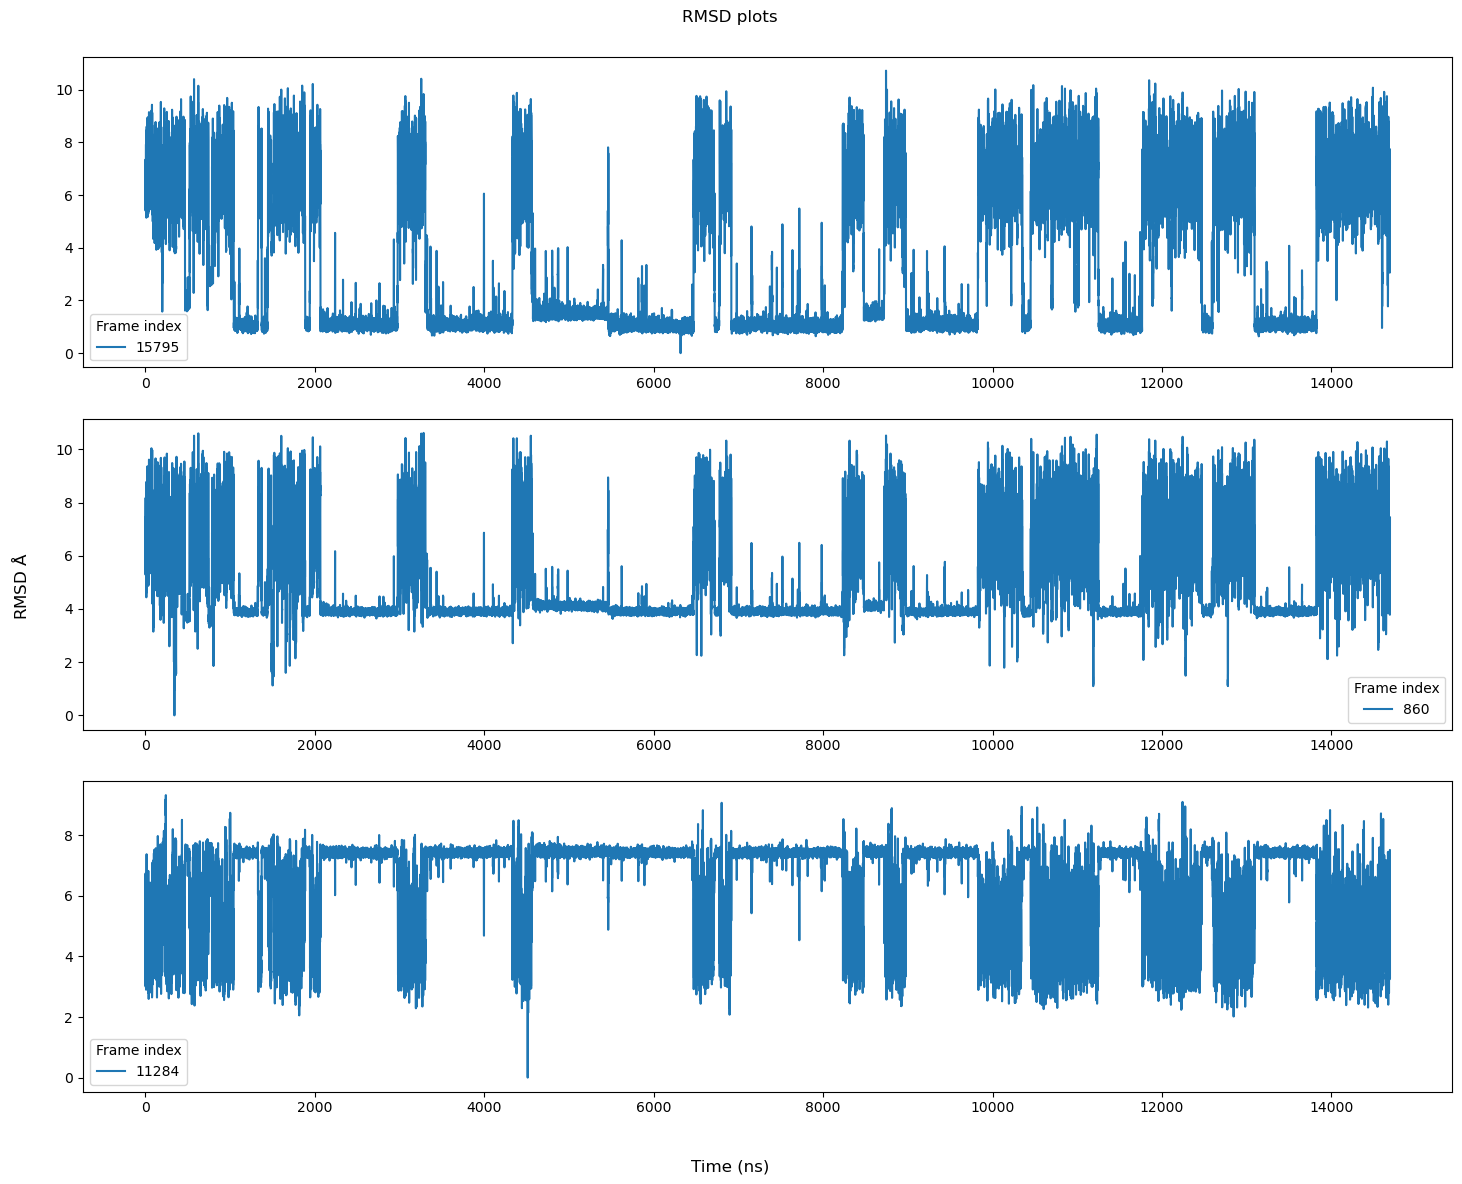

In [43]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 12))

for rmsd, ax, refidx in zip(full_rmsds, axs.flat, refs):
    ax.plot(np.arange(full_rmsds[0].shape[0])*0.4, rmsd, label=refidx)
    ax.legend(title="Frame index")
fig.supxlabel("Time (ns)")
fig.supylabel(r"RMSD $\mathrm{\AA}$")
fig.suptitle("RMSD plots")
fig.tight_layout(pad=2)

In [123]:
full_cuts, models = ra.get_cuts(full_hist, n_components=2, height=5, return_models=True)

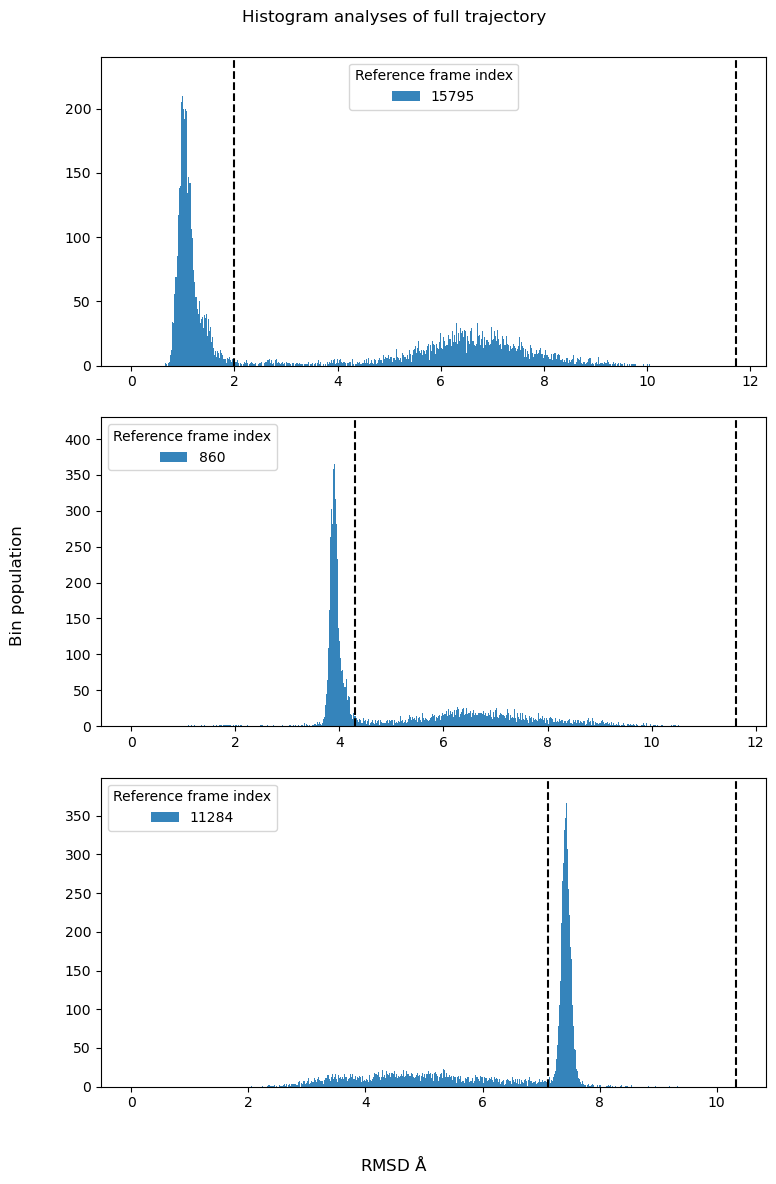

In [125]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 12))

for cut, hist, idx, ax in zip(full_cuts, full_hist, refs, axs.flat):
    bin_centers = (hist[1][1:] + hist[1][:-1]) / 2
    ax.bar(bin_centers, hist[0], 
            label=str(idx), 
            width=(bin_centers[1] - bin_centers[0]),
            alpha=0.9)
    
    for c in cut:
        if c is not None:
            ax.axvline(c, color='k', ls='--')
    
    ax.legend(title="Reference frame index")
    
fig.supxlabel(r"RMSD $\mathrm{\AA}$")
fig.supylabel("Bin population")
fig.suptitle("Histogram analyses of full trajectory")
fig.tight_layout(pad=2)


From above, the third one has several identified regions, which we shall further analyze.

In [26]:
# Using refs[0] and the corresponding RMSD - rmsds1[0] for analyses
cuts = np.append([0], np.array(full_cuts[2])[np.not_equal(full_cuts[2], None)])
rmsds = full_rmsds[2]
peaks = [np.where(np.logical_and(np.less(rmsds, high), np.greater_equal(rmsds, low)))[0] for low, high in zip(cuts[:-1], cuts[1:])]

In [27]:
cluster_counter = 1
c_traj_paths = []
for peak in peaks:
    u = mda.Universe(top, coords[peak])
    
    for ts, pos in zip(u.trajectory, coords[peak, :, :]):
        ts.positions = pos
    
    with mdawriter("cluster" + str(cluster_counter) +".nc", u.atoms.n_atoms) as w:
        for ts in u.trajectory:
            w.write(u)

    c_traj_paths.append(Path.cwd().joinpath("cluster" + str(cluster_counter) +".nc").as_posix())
    
    cluster_counter += 1

## Second set of RMSDs

The analyses will be performed for the first three clusters, the last one is assumed to only contain unfolded structures.

In [28]:
# Cluster trajectories extracted next
c_trajs1 = [mda.Universe(top, c_path) for c_path in c_traj_paths[:]]

In [29]:
# Generate reference frame indices for each cluster
c_refs1_ = [np.random.randint(low=0, high=len(peak), size=nrefs) for peak in peaks[:]]

In [30]:
c_coords = [c_traj.trajectory.timeseries() for c_traj in c_trajs1]

In [31]:
c_refs1 = [[mda.Universe(top, c_coord[c_ref, :, :]) for c_ref in c_refs] for c_refs, c_coord in zip(c_refs1_, c_coords)]

In [42]:
rmsds1 = []
for c_traj, c_refs in zip(c_trajs1, c_refs1):
    ra.traj = c_traj
    ra.refs = c_refs
    rmsds1.append(ra.get_similarity_metric(filenames=["1.nc", "2.nc", "3.nc"], select="nucleic and not type H*"))
    Path.unlink("./1.nc")
    Path.unlink("./2.nc")
    Path.unlink("./3.nc")

In [46]:
bin_rmsds1 = [ra.bin_frames(rmsd1, bins=np.shape(rmsd1)[-1]//10) for rmsd1 in rmsds1]

In [47]:
cuts1 = [ra.get_cuts(bin_rmsd1, max_components=10, height=0) for bin_rmsd1 in bin_rmsds1]

It might also be necessary to manually choose the reference frame when the population of outliers is really low. This is the case in the first peak i.e. the first row of RMSD plots. We clearly see that there are two regions which stand out. Another method to deal with this would be to plot the histogram and manually select a cut-off. A third possible way to treat this would be change the parameters of the function that computes cut-offs. 

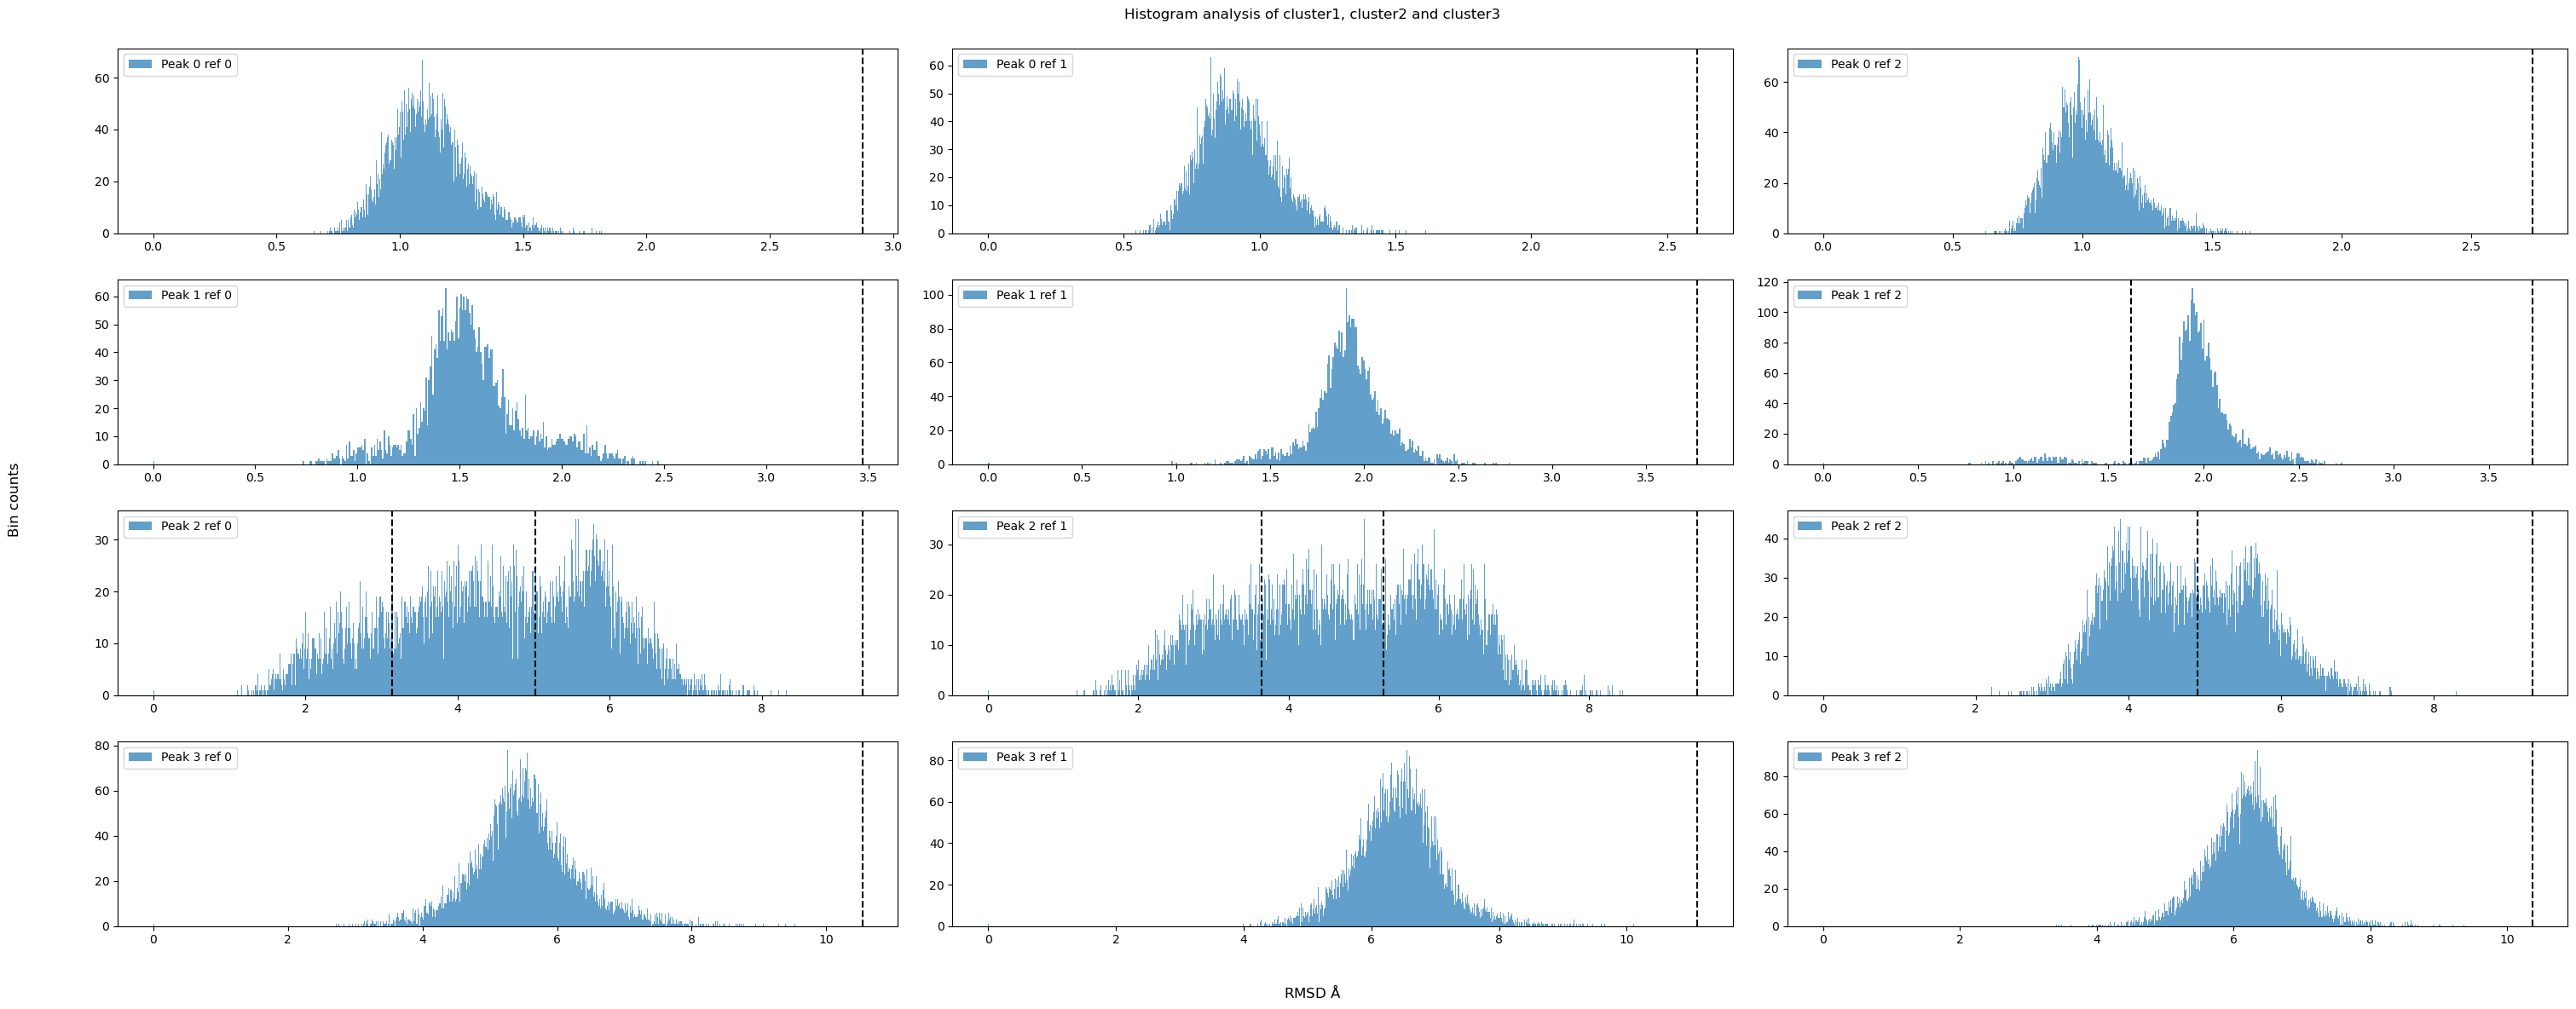

In [53]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 12))

fig.suptitle("Histogram analysis of cluster1, cluster2 and cluster3")
fig.supxlabel(r"RMSD $\mathrm{\AA}$")
fig.supylabel("Bin counts", x=-0.01)

for i in range(len(c_trajs1)):
    peak_rmsd_hist = bin_rmsds1[i]
    peak_hist_cuts = cuts1[i] 
    peak_axs = axs[i]
    
    for j in range(nrefs):
        ref_rmsd_hist = peak_rmsd_hist[j]
        ref_hist_cuts = peak_hist_cuts[j] 
        ax = peak_axs[j]
        label = c_refs1_[i][j]
        
        bin_centers = (ref_rmsd_hist[1][1:] + ref_rmsd_hist[1][:-1]) / 2
        bin_width = bin_centers[1] - bin_centers[0]
        
        ax.bar(bin_centers, ref_rmsd_hist[0], bin_width, alpha=0.7, label="Peak " + str(i) + " ref " + str(j))
        
        for peak_cut in ref_hist_cuts:
            if peak_cut is not None:
                ax.axvline(peak_cut, linestyle='--', color='k')

        ax.legend()

fig.tight_layout(pad=2)

From the plots above, it is hard to obtain clearly defined states in the first, third and fourth clusters. It is fairly clear in the RMSD plots for the third cluster that there are several different states. To further analyze the structures, we can either directly perform clustering on the obtained separated "clusters" or perform a native contacts analysis using the obtained structures to see if that better separates the structures.

In [6]:
# Native contacts analysis instance for example1
nc = traj_classification.NativeContactAnalysis()

In [55]:
natcons1 = []
for c_traj, c_refs in zip(c_trajs1, c_refs1):
    nc.traj = c_traj
    nc.refs = c_refs
    natcons1.append(nc.get_similarity_metric(cut_off=4.5, nonoh=False, ids=[3, 4, 5], skip_neighs=0, method="soft", atom_selection=" nucleic"))

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
np.unique(np.round(natcons1[1][1][1], decimals=2), return_counts=True)

(array([0.77, 0.78, 0.8 , 0.81, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,
        0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 array([   2,    1,    1,    4,    1,    3,    2,    1,    2,    3,    9,
           9,   20,   36,   87,   28,    4,    2,   13,  195, 2496,  701]))

In [87]:
np.where(np.equal(np.round(natcons1[1][1][1], decimals=3), ))[0].shape

(680,)

In [88]:
len(np.round(natcons1[1][1][1], decimals=2))

3620

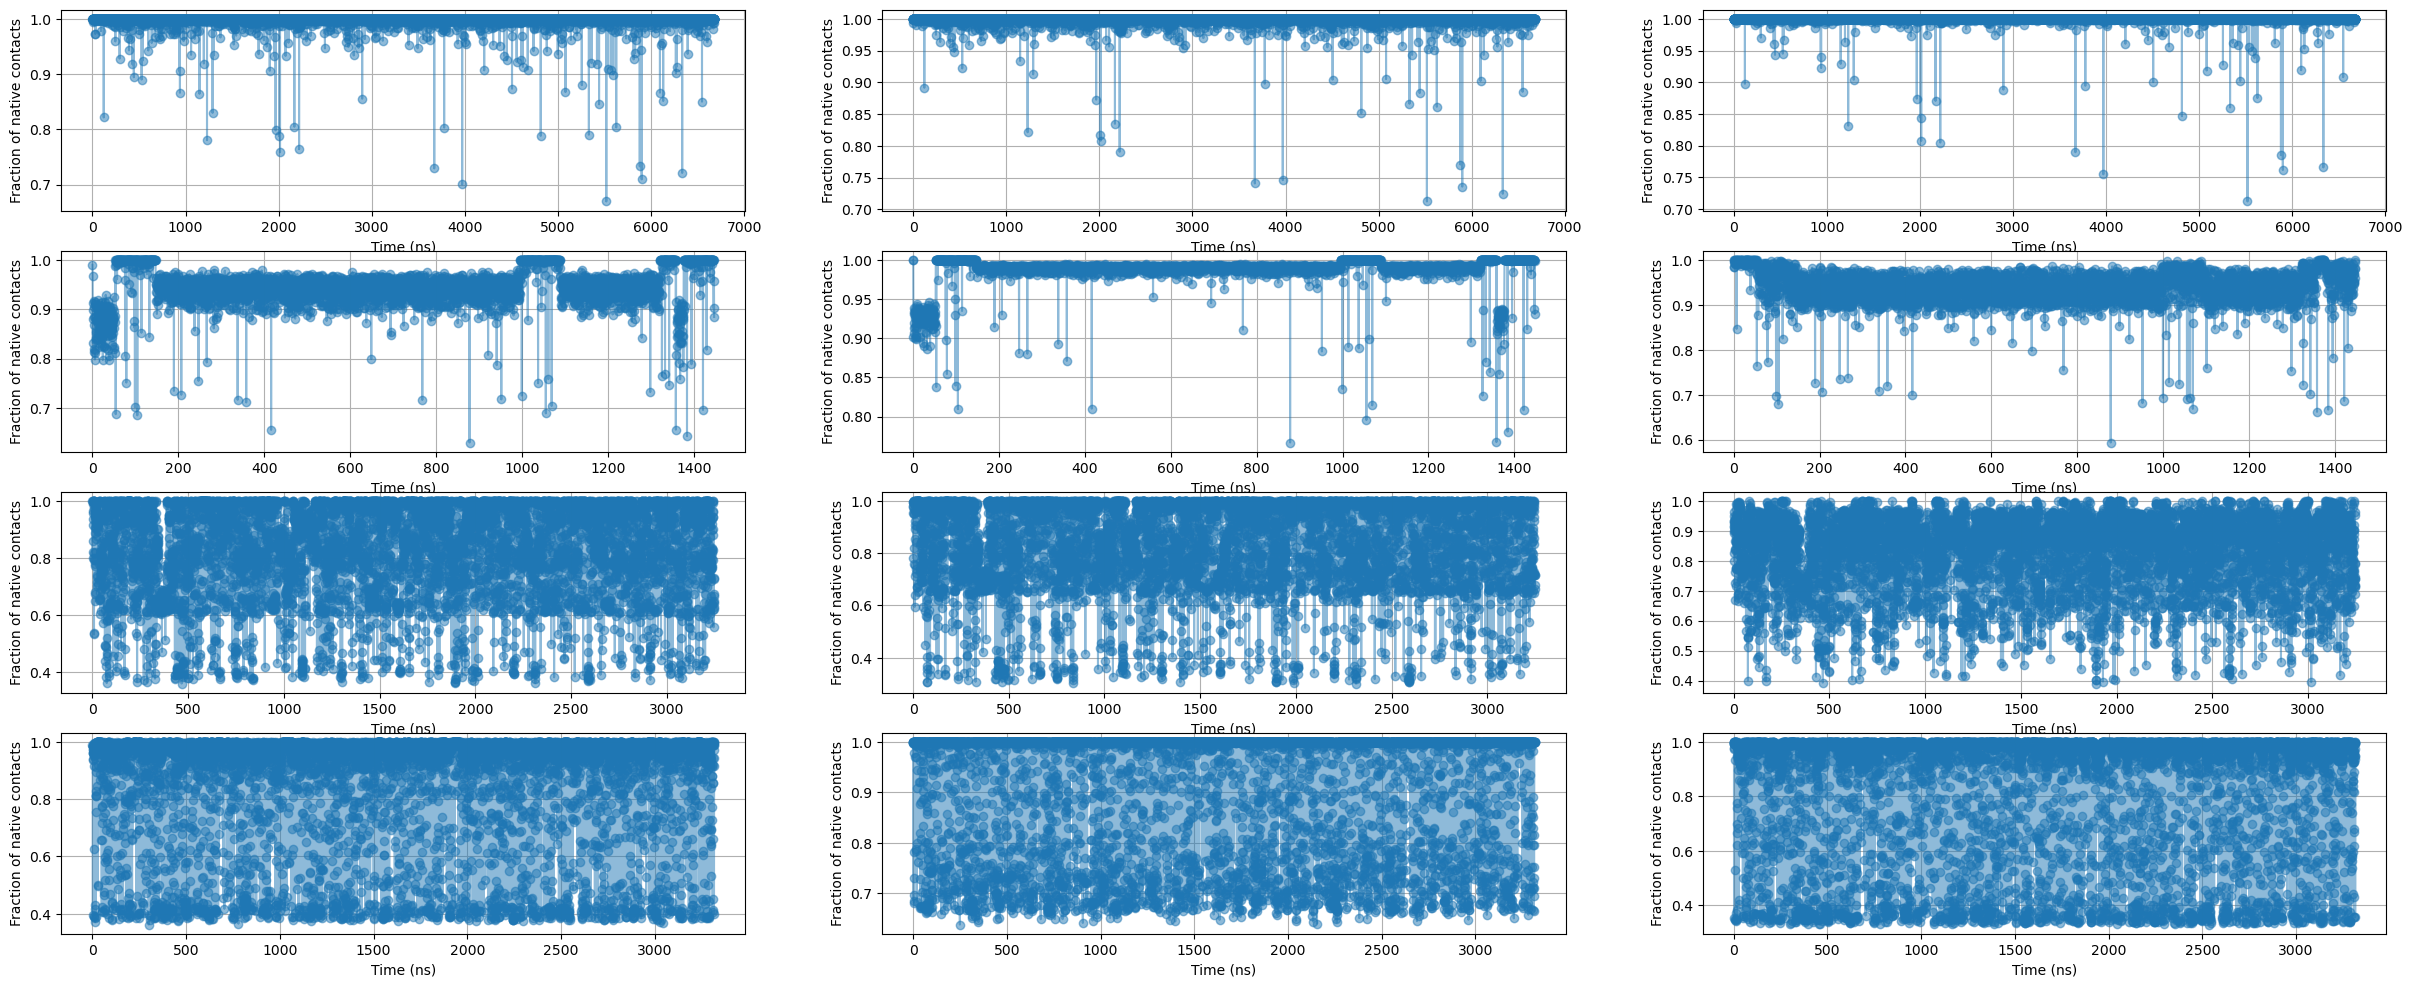

In [67]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 12))

for natcons, axi in zip(natcons1, axs):
    for natcon, ax in zip(natcons, axi):
        ax.plot(natcon[0]*0.4, natcon[1], marker='o', alpha=0.5)
        ax.grid(True)
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Fraction of native contacts")

In [68]:
bin_natcons1 = [nc.bin_frames(natcon1, bins=binsize, range=natcon_range) for natcon1, binsize, natcon_range in zip(natcons1, [700, 140, 350, 350], [(0.8, 0.999), (0.4, 0.999), (0.3, 0.999), (0.3, 0.999)])]

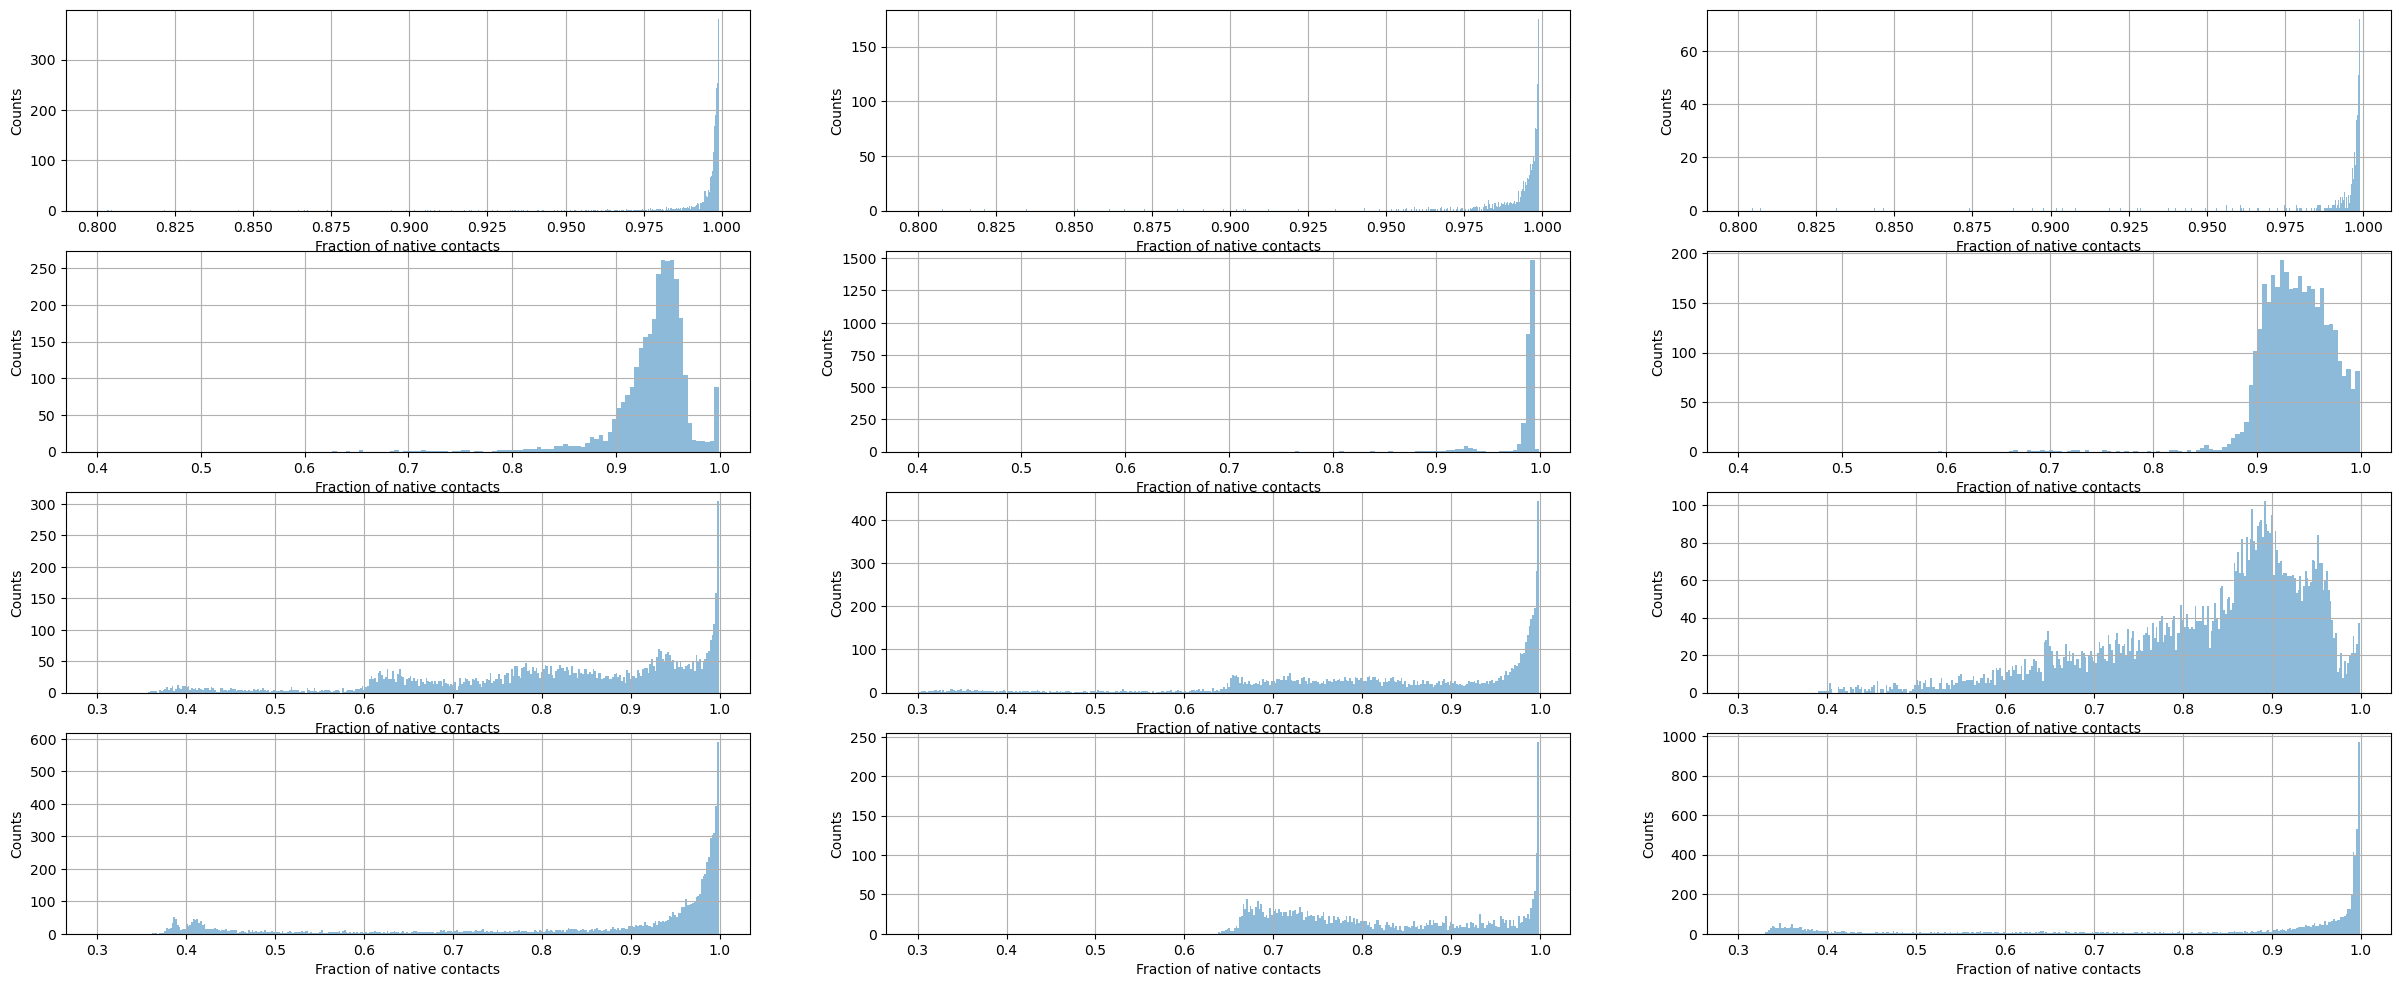

In [69]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 12))

for bin_natcons, axi in zip(bin_natcons1, axs):
    for bin_natcon, ax in zip(bin_natcons, axi):
        bin_centers = (bin_natcon[1][1:] + bin_natcon[1][:-1]) / 2
        bin_width = bin_centers[1] - bin_centers[0]
        ax.bar(bin_centers, bin_natcon[0], alpha=0.5, width=bin_width)
        ax.grid(True)
        ax.set_xlabel("Fraction of native contacts")
        ax.set_ylabel("Counts")
        

In [101]:
nc_cuts1 = [nc.get_cuts(bin_natcon1, max_components=7, height=5) for bin_natcon1 in bin_natcons1]

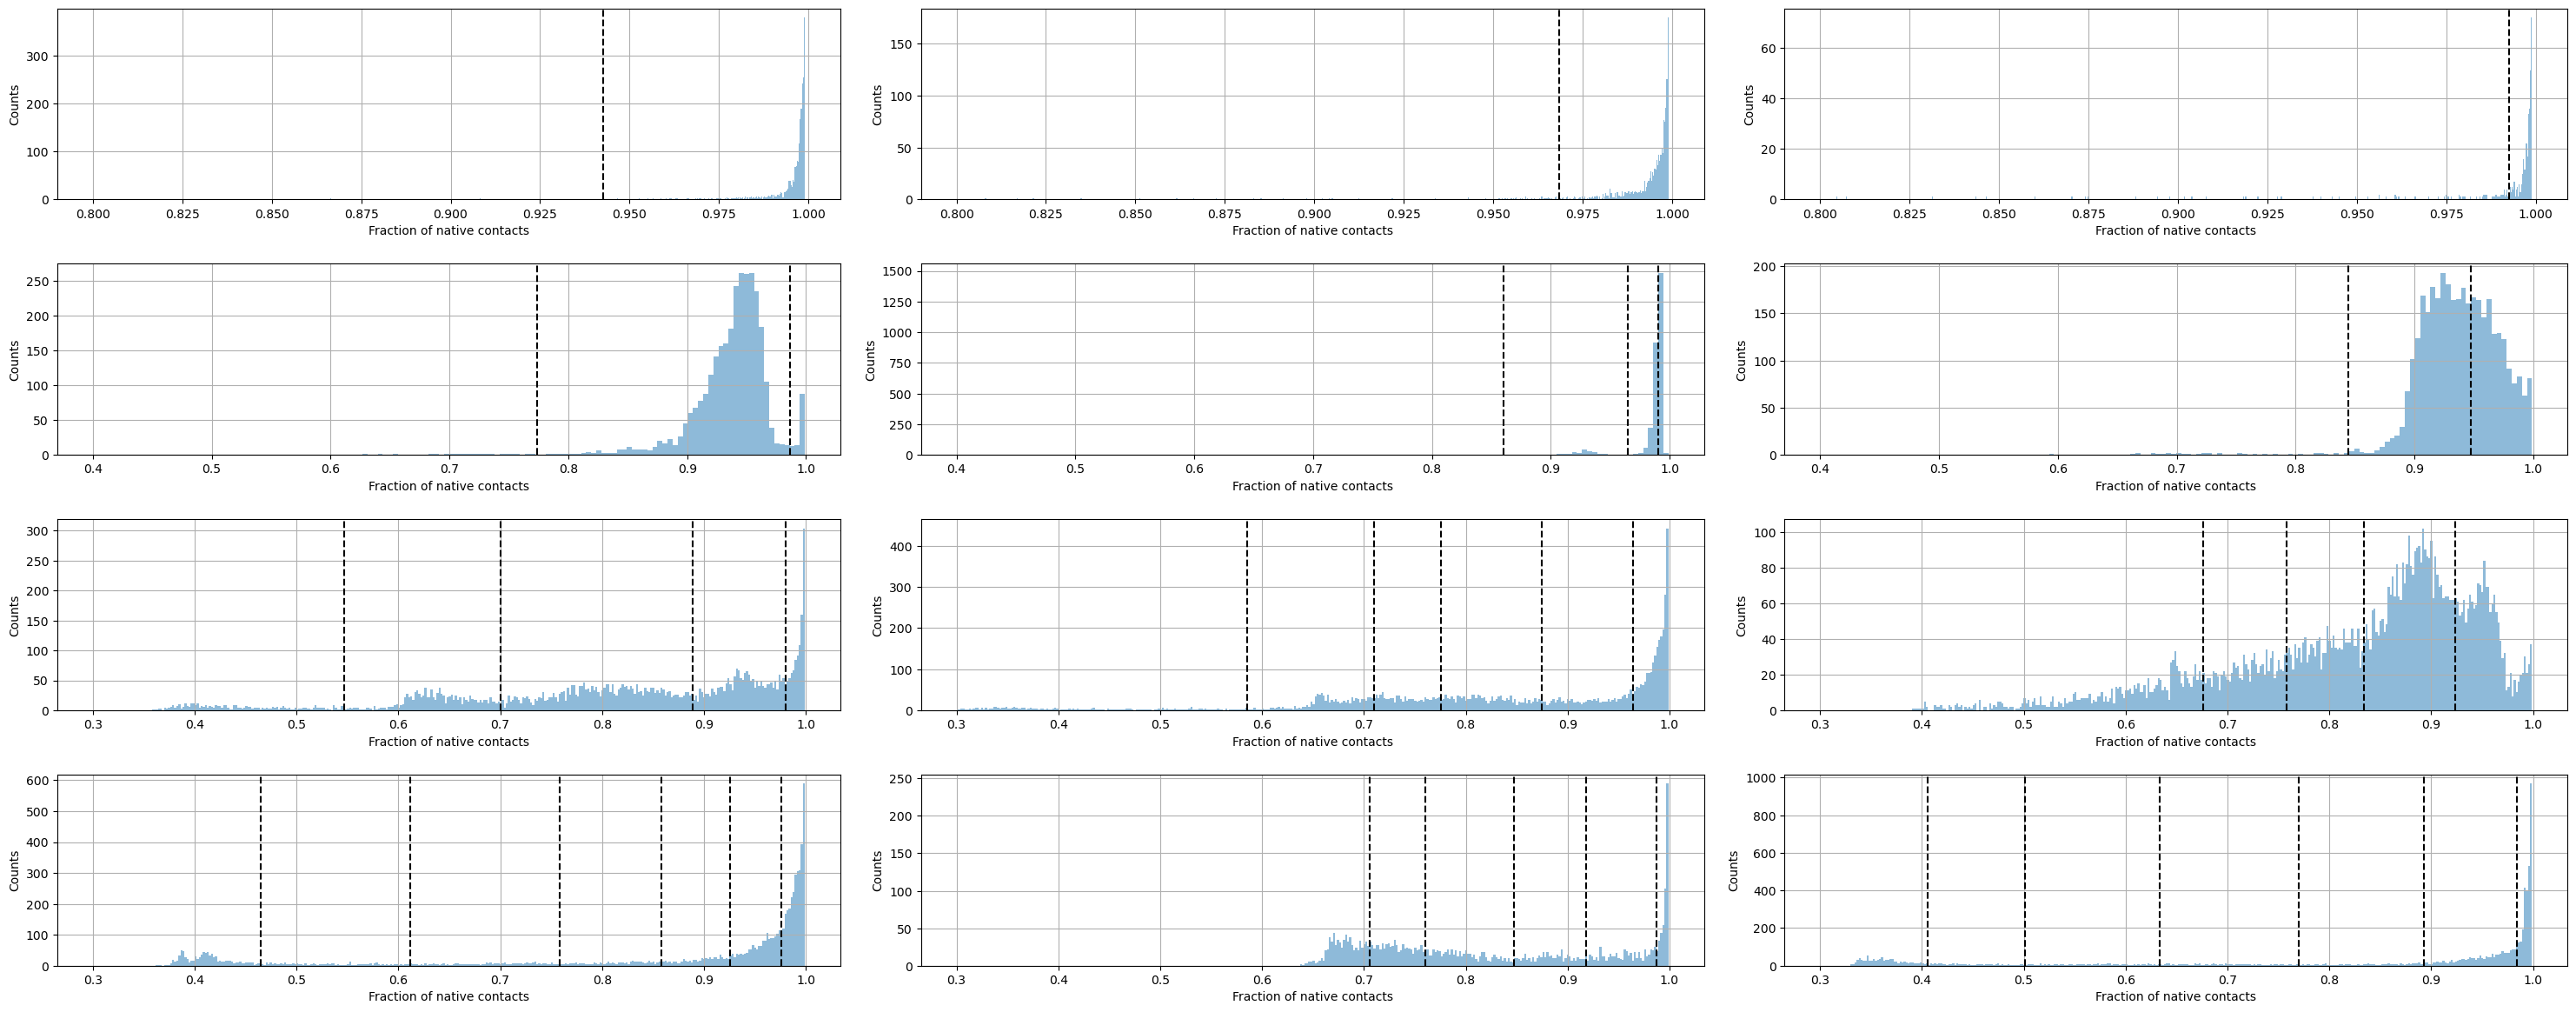

In [102]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 12))

for bin_natcons, nc_cuts, axi in zip(bin_natcons1, nc_cuts1, axs):
    for bin_natcon, nc_cut, ax in zip(bin_natcons, nc_cuts, axi):
        bin_centers = (bin_natcon[1][1:] + bin_natcon[1][:-1]) / 2
        bin_width = bin_centers[1] - bin_centers[0]
        ax.bar(bin_centers, bin_natcon[0], alpha=0.5, width=bin_width)
        ax.grid(True)
        for cut in nc_cut:
            if cut > 0 :
                ax.axvline(cut, color='k', ls='--')
        ax.set_xlabel("Fraction of native contacts")
        ax.set_ylabel("Counts")

fig.tight_layout(pad=2)

It should be clear from above that this method can separate states slightly better. The states in the first peak from the full dataset seems fairly uniform with few outliers. The states in the second peak which were not well separated in the RMSD plots is actuall fairly well separated in the native contacts analysis.

In [115]:
rmsds1[1][2].shape

(3620,)

In [108]:
# Using refs[0] and the corresponding RMSD - rmsds1[0] for analyses
cuts = [np.append(np.append([0], np.array(nc_cuts1[i][j])[np.not_equal(nc_cuts1[i][j], None)]), [1]) for i, j in [(0, 2), (1, 2), (2, 0)]]
rmsds = [rmsds1[i][j] for i, j in [(0, 2), (1, 2), (2, 0)]]
peaks = [[np.where(np.logical_and(np.less(rmsd, high), np.greater_equal(rmsd, low)))[0] for low, high in zip(cut[:-1], cut[1:])] for rmsd, cut in zip(rmsds, cuts)]

In [112]:
peaks[1]

[array([ 44,  77,  81, 101]),
 array([   3,   12,   29,   49,   71,   72,   84,   89, 3409, 3415, 3431]),
 array([  26,   42,   51,   88,   95, 3422])]

In [27]:
cluster_counter = 1
c_traj_paths = []
for peak in peaks:
    u = mda.Universe(top, coords[peak])
    
    for ts, pos in zip(u.trajectory, coords[peak, :, :]):
        ts.positions = pos
    
    with mdawriter("cluster" + str(cluster_counter) +".nc", u.atoms.n_atoms) as w:
        for ts in u.trajectory:
            w.write(u)

    c_traj_paths.append(Path.cwd().joinpath("cluster" + str(cluster_counter) +".nc").as_posix())
    
    cluster_counter += 1

## Testing the RMSD calculation in a one liner for the aligned trajectories

In [101]:
# Importing aligned trajectories
al_traj = mda.Universe(top, "aligned1.nc")

In [73]:
%%timeit

rms_RMSD = rms.RMSD(atomgroup=al_traj, reference=full_refs[0], select="nucleic and not type H*").run()

1.53 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
%%timeit

atom_positions = al_traj.trajectory.timeseries(atomgroup=al_traj.select_atoms("nucleic and not type H*"))
ref_positions = full_refs[0].select_atoms("nucleic and not type H*").positions
temp_rmsds = np.sqrt(np.power(np.linalg.norm(np.subtract(atom_positions, ref_positions), axis=-1), 2).mean(axis=1))

461 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
%%timeit

atom_positions = al_traj.trajectory.timeseries(atomgroup=al_traj.select_atoms("nucleic and not type H*"))
ref_positions = full_refs[0].select_atoms("nucleic and not type H*").positions
rms_rmsd = [rms.rmsd(pos, ref_positions) for pos in atom_positions]

542 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like if the trajectories were pre-aigned, the direct numpy based calculation is significantly faster. But often, these analyses won't use aligned trajectories which begs the question of whether I should use it at all. Also, the code was warmed up in the computations above. So again, there's this question of whether the RMSD changed the outcome by a lot.